# Projeto 1 - Métodos não supervisionados

Aluno: André Soranzzo Mota RA: 166404

Aluna: Rebecca Moreira Messias RA: 186416

## Objetivos

Esse projeto tem como objetivo implementar dois métodos de aprendizado de máquina não supervisionados. O primeiro, sugerido pela professora, foi o K-Means e o segundo, de escolha do grupo, foi o DBSCAN. Outra atividade prevista é treinar nosso algoritmo com duas bases diferentes: uma bidimensional dada pela professora e outra de várias dimensões escolhida pelo grupo. Para os dados está mapeado fazer algumas manipulações como separar os datasets em treino e teste e fazer normalizações necessárias. Por fim, na última parte do trabalho iremos aplicar o PCA no nosso dataset de várias dimensões para reduzir sua dimensionalidade.

## Importação e instalação de bibliotecas

As bibliotecas utilizadas neste projeto foram: 
- **matplotlib**: plotar os gráficos
- **numpy**: manipular arrays
- **pandas**: manipular os dados
- **sklearn**: redução de dimensionalidade e normalização dos dados

In [3]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install scipy
!pip install sklearn

     |████████████████████████████████| 10.3 MB 9.3 MB/s eta 0:00:01
     |████████████████████████████████| 15.3 MB 69.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 38.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 49.2 MB/s eta 0:00:01
     |████████████████████████████████| 9.9 MB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 27.4 MB 809 kB/s  eta 0:00:01
     |████████████████████████████████| 22.3 MB 15.8 MB/s eta 0:00:01   |▎                               | 194 kB 7.9 MB/s eta 0:00:03
     |████████████████████████████████| 303 kB 26.9 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=fe3d448e15d9050db0897013b7d7002e46561a602f21ada7f5775fed0188aff5
  Stored in directory: /home/jovyan/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [4]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import cycle, islice
from scipy.spatial import distance
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import queue
import copy
import random

## Parte 1 - Métodos de clusterização

Nesta primeira parte, foi realizada a implementação do algoritmo K-Means e DBSCAN, ambos métodos de clustering. Os datasets utilizados foram:
- **cluster.dat** : fornecido no enunciado do exercício
- **heart.csv** : um dataset para classificação de ataques cardíacos, obtido através do link a seguir: https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

Em cada dataset serão aplicados os seguintes procedimentos:
- Separação (split) dos dados em conjuntos de dados de treino/teste, na proporção de 90/10.
- Aplicação de pré-processamentos como normalização e feature scaling.
- Treinar os métodos utilizando o respectivo dataset.
- Avaliar diferentes números de clusters visando obter a melhor configuração, através de algoritmos como Silhouette coefficient, elbow, etc.
- Utilizar métricas para avaliar os experimentos, como cluster distance, density, etc.
- Escolher os melhores modelos e testá-los com o conjunto de testes. Mostrar também a qual cluster os novos dados foram atribuídos.

### 1.1 - Implementação do método K-Means

Abaixo temos a implementação do primeiro algoritmo de clustering que será utilizado nos datasets, o kmeans.

In [5]:
def inicializaCentroides(k, data):
    centroides = []
    for i in range(0,k):
        centroides.append(data.loc[[i]])
    return centroides

def calculaDistancia(ponto1, ponto2):
    ponto1 = ponto1.to_numpy()
    ponto2 = ponto2.to_numpy()[0]
    return distance.euclidean(ponto1, ponto2)

def encontraCentroideMaisProximo(ponto, centroides, k):
    isFirst = True
    centroide = 0
    menorDistancia = -1
    for i in range(0,len(centroides)):        
        dist = calculaDistancia(ponto, centroides[i])
        if (isFirst):
            menorDistancia = dist
            isFirst = False
        elif (dist < menorDistancia):
            menorDistancia = dist
            centroide = i
    return centroide

def populaClusters(centroides, data, k):
    clusters = []
    for i in range(0,k):
        clusters.append([])
    for index, i in data.iterrows():
        
        centroide = encontraCentroideMaisProximo(i, centroides, k)
        clusters[centroide].append(i.to_numpy())
    return clusters

def recalculaCentroides(k, centroides, clusters):
    for i in range(0,k):
        mediax=0
        mediay=0
        tam_cluster=len(clusters[i])
        for j in range(0, tam_cluster):
            mediax+=clusters[i][j][0]
            mediay+=clusters[i][j][1]
        mediax = mediax/tam_cluster
        mediay = mediay/tam_cluster
        centroides[i][0] = mediax
        centroides[i][1] = mediay
    return centroides
        
def loop_kmeans(centroides, data, k):
    clusters = populaClusters(centroides, data, k)
    centroidesAntes = copy.deepcopy(centroides)
    centroides = recalculaCentroides(k, centroides, clusters)
    return centroidesAntes, centroides, clusters
        
def convergiu(centroidesAntes, centroidesDepois, k):
    mudou = False
    for i in range(0,k):
        pontoAntes = centroidesAntes[i].to_numpy()
        pontoDepois = centroidesDepois[i].to_numpy()
        if(pontoAntes.all() == pontoDepois.all()):
            mudou = True
    return mudou
        
def kmeans(k, data, iteracoes):
    centroides = inicializaCentroides(k, data)
    clusters = populaClusters(centroides, data, k)
    
    centroidesAntes = copy.deepcopy(centroides)
    centroides = recalculaCentroides(k, centroides, clusters)
    mudou = True
    cont = 0
    while(mudou==True and cont < iteracoes):
        centroidesAntes, centroides, clusters = loop_kmeans(centroides, data, k)
        mudou = convergiu(centroidesAntes, centroides, k)
        cont = cont + 1
    return clusters, centroides

### 1.2 - Implementação do método DBSCAN

Abaixo temos a implementação deste que será o segundo método de clustering utilizado nos datasets, o DBSCAN.

In [6]:
class CustomDBSCAN():
    def __init__(self):
        self.central = -1
        self.borda = -2

    def pontosVizinhos(self, data, pontoId, distancia):
        pontos = []
        for i in range(len(data)):
            if np.linalg.norm([a_i - b_i for a_i, b_i in zip(data[i], data[pontoId])]) <= distancia:
                pontos.append(i)
        return pontos

    def fit(self, data, Eps, MinPt):
        ponto_labels = [0] * len(data)
        ponto_contador = []

        pontos_centrais = []
        pontos_borda = []

        for i in range(len(data)):
            ponto_contador.append(self.pontosVizinhos(data, i, Eps))

        for i in range(len(ponto_contador)):
            if (len(ponto_contador[i]) >= MinPt):
                ponto_labels[i] = self.central
                pontos_centrais.append(i)
            else:
                pontos_borda.append(i)

        for i in pontos_borda:
            for j in ponto_contador[i]:
                if j in pontos_centrais:
                    ponto_labels[i] = self.borda
                    break

        cluster = 1
        
        for i in range(len(ponto_labels)):
            q = queue.Queue()
            if (ponto_labels[i] == self.central):
                ponto_labels[i] = cluster
                for x in ponto_contador[i]:
                    if(ponto_labels[x] == self.central):
                        q.put(x)
                        ponto_labels[x] = cluster
                    elif(ponto_labels[x] == self.borda):
                        ponto_labels[x] = cluster
                while not q.empty():
                    vizinhos = ponto_contador[q.get()]
                    for y in vizinhos:
                        if (ponto_labels[y] == self.central):
                            ponto_labels[y] = cluster
                            q.put(y)
                        if (ponto_labels[y] == self.borda):
                            ponto_labels[y] = cluster
                cluster += 1

        return ponto_labels, cluster

    def visualize(self, data, cluster, qtdClusters):
        N = len(data)

        cores = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                         for i in range(qtdClusters)]
        
        for i in range(qtdClusters):
            if (i == 0):
                cor = '#000000'
            else:
                cor = cores[i % len(cores)]

            x, y = [], []
            for j in range(N):
                if cluster[j] == i:
                    x.append(data[j][0])
                    y.append(data[j][1])
            plt.scatter(x, y, c=cor, alpha=1, marker='.')
        plt.show()

### 1.3 - Primeiro dataset: cluster.dat

Vamos começar então com os dados do enunciado, o *cluster.dat*. Abaixo, temos a importação e normalização dos dados com a bilioteca StandardScaler do SKLearn.

In [7]:
dataset = pd.read_table("cluster.dat", sep=" ", header=None)

normalized_dataset = StandardScaler().fit_transform(dataset)

Agora, iremos separar essa nossa base de dados em teste e treinamento. Usaremos 90% da nossa base para treinamento e 10% para teste.

In [8]:
dataset = pd.DataFrame(normalized_dataset)

X = dataset.iloc[:, 0:1].values
Y = dataset.iloc[:, 1:2].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

df1_training = pd.DataFrame(X_train)
df2_training = pd.DataFrame(y_train)

df1_test = pd.DataFrame(X_test)
df2_test = pd.DataFrame(y_test)

df_training = pd.concat([df1_training, df2_training], axis=1)
df_test = pd.concat([df1_test, df2_test], axis=1)

df_training = df_training.to_numpy()
df_test = df_test.to_numpy()

Após fazer o split dos dados e fazer a normalização, iremos treinar com nossa base de treinamento no K-Means. Abaixo podemos ver o resultado. Para isso escolhemos montar 3 clusters e limitamos nosso algoritmo de fazer até 100 vezes o looping.

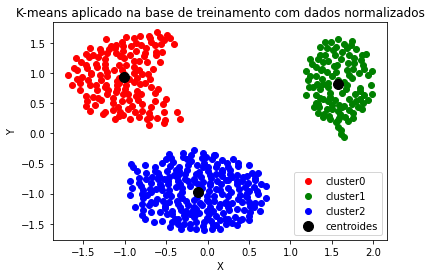

In [9]:
clusters, centroides = kmeans(3, pd.DataFrame(df_training), 100)

cores = ['r', 'g', 'b']
for i in range(0,len(clusters)):
    arr = np.array(clusters[i])
    x, y = arr.T
    plt.scatter(x, y, c=cores[i], label='cluster'+str(i))

arr_centroides = np.array(centroides)
x, y = arr_centroides.T
plt.scatter(x, y, 100, c='black', label='centroides')
    
plt.xlabel('X')
plt.ylabel('Y')
plt.title("K-means aplicado na base de treinamento com dados normalizados")
plt.legend()
plt.show()

Para efeito de comparação, exibiremos o mesmo gráfico, porém com os dados não normalizados.

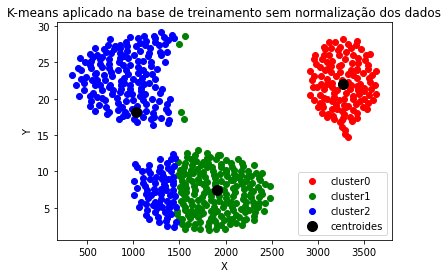

In [10]:
dataset = pd.read_table("cluster.dat", sep=" ", header=None)

clusters, centroides = kmeans(3, dataset, 100)

cores = ['r', 'g', 'b']
for i in range(0,len(clusters)):
    arr = np.array(clusters[i])
    x, y = arr.T
    plt.scatter(x, y, c=cores[i], label='cluster'+str(i))

arr_centroides = np.array(centroides)
x, y = arr_centroides.T
plt.scatter(x, y, 100, c='black', label='centroides')
    
plt.xlabel('X')
plt.ylabel('Y')
plt.title("K-means aplicado na base de treinamento sem normalização dos dados")
plt.legend()
plt.show()

Nota-se que o kmeans classifica muito melhor os conjuntos quando os dados são normalizados. Podemos ver que o centroide do cluster2 está mais próximo do centroide do cluster1 na figura com os dados normalizados, ou seja, a normalização dos dados fez que fossem obtidos valores dos centroides mais condizentes com a realidade esperada.

E agora iremos treinar coma mesma base de treinamento no DBSCAN.

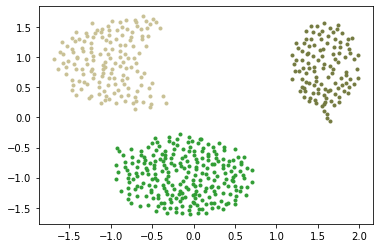

In [11]:
custom_DBSCAN = CustomDBSCAN()
ponto_labels, clusters = custom_DBSCAN.fit(df_training, 0.25, 4)

custom_DBSCAN.visualize(df_training, ponto_labels, clusters)

Com esses resultados podemos ver que nossos algoritmos conseguiu classificar bem os dados com as bases de treinamento criando 3 clusters. Agora iremos fazer uma análise de como o K-Means se comporta com diferentes números de clusters passado por parâmetro. Essa análise será feita através do Silhouette Coefficient.

Se a quantidade de clusters for 2 , a média do Silhouette Coefficient é: 0.39671087997870125
Se a quantidade de clusters for 3 , a média do Silhouette Coefficient é: 0.4934390321065685
Se a quantidade de clusters for 4 , a média do Silhouette Coefficient é: 0.4001760096015442
Se a quantidade de clusters for 5 , a média do Silhouette Coefficient é: 0.31994897524905347
Se a quantidade de clusters for 6 , a média do Silhouette Coefficient é: 0.21896710916843878


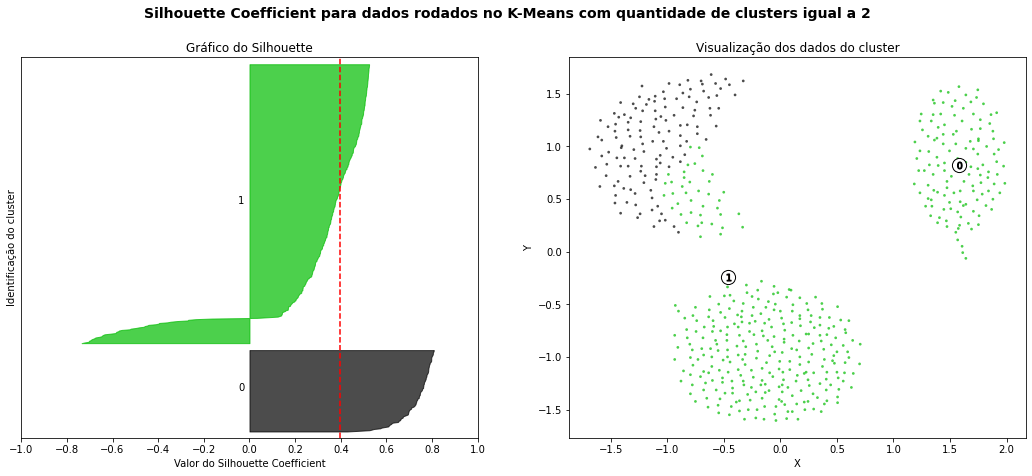

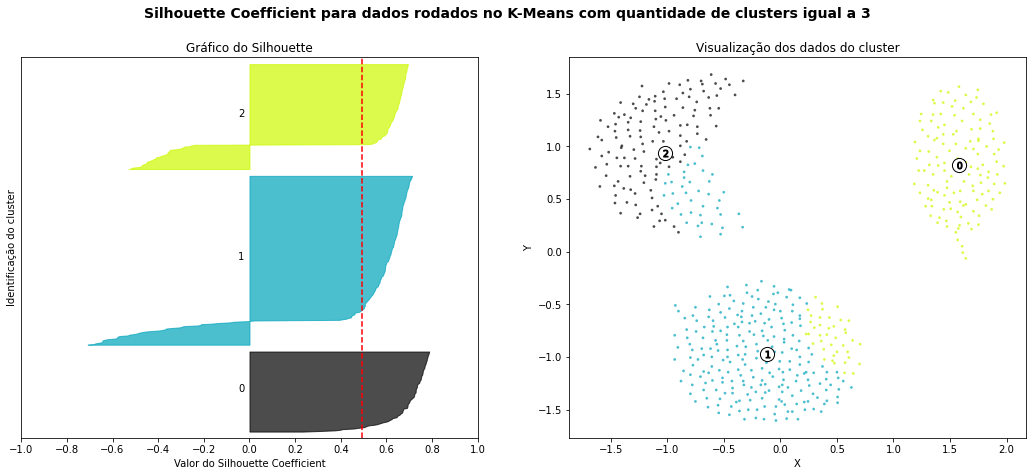

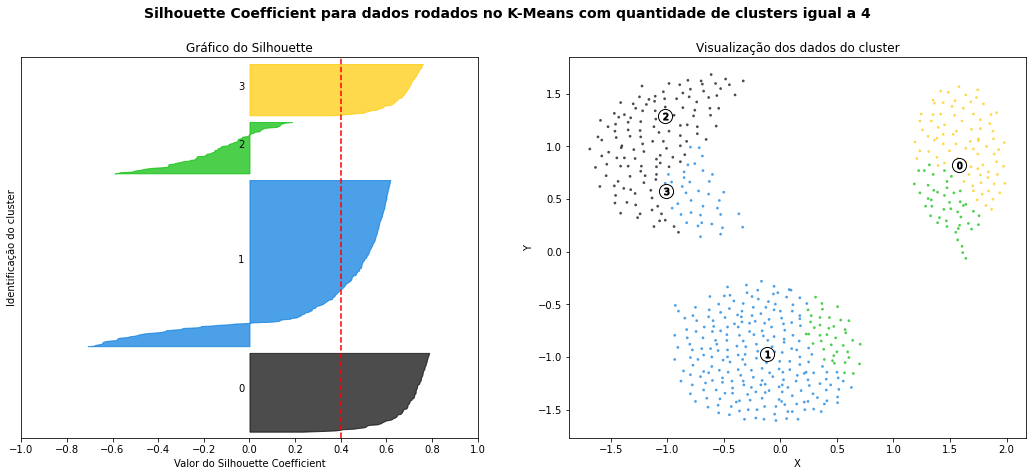

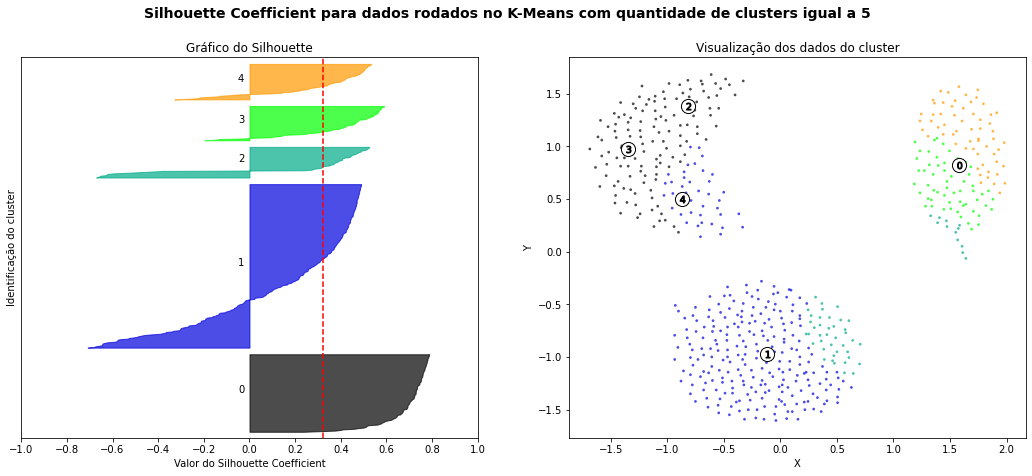

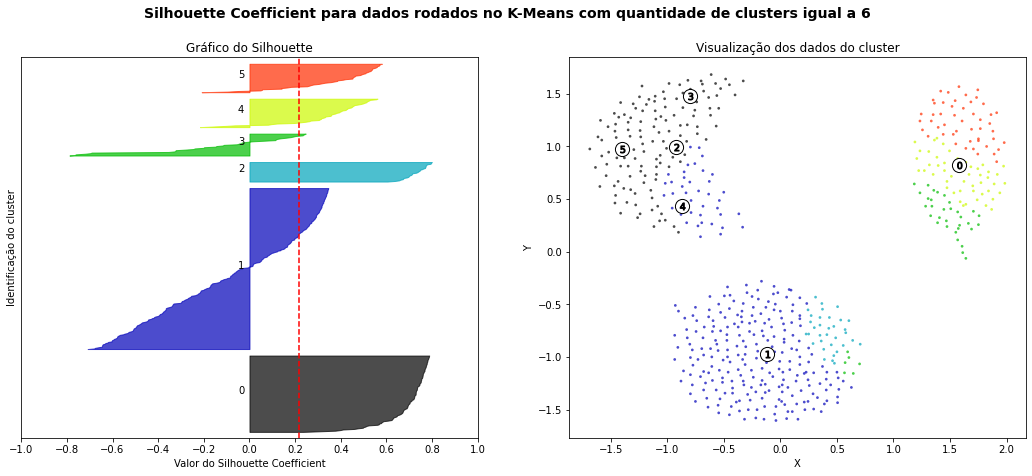

In [12]:
X = normalized_dataset

intervalo_qtd_clusters = [2, 3, 4, 5, 6]

for qtd_clusters in intervalo_qtd_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (qtd_clusters + 1) * 10])

    clusters, centroides = kmeans(qtd_clusters, pd.DataFrame(X), 100)
    cluster_labels = np.array([])
    centroides_array = []
    
    centroides = np.asarray(centroides)
    
    for i in range(0, len(centroides)):
        centroides_array.append(centroides[i][0])
        
    centroides_array = np.asarray(centroides_array)
    
    for i in range(0,len(clusters)):
        arr = np.array(clusters[i])
        x, y = arr.T
        for j in range(0, len(x)):
            cluster_labels = np.append(cluster_labels, i)

    silhouette_media = silhouette_score(X, cluster_labels)
    print("Se a quantidade de clusters for", qtd_clusters,
          ", a média do Silhouette Coefficient é:", silhouette_media)

    amostra_valores_silhouette = silhouette_samples(X, cluster_labels)

    y_menor = 10
    for i in range(qtd_clusters):
        cluster_silhouette_valores_i = \
            amostra_valores_silhouette[cluster_labels == i]

        cluster_silhouette_valores_i.sort()

        tamanho_cluster_i = cluster_silhouette_valores_i.shape[0]
        y_maior = y_menor + tamanho_cluster_i

        cor = cm.nipy_spectral(float(i) / qtd_clusters)
        ax1.fill_betweenx(np.arange(y_menor, y_maior),
                          0, cluster_silhouette_valores_i,
                          facecolor=cor, edgecolor=cor, alpha=0.7)

        ax1.text(-0.05, y_menor + 0.5 * tamanho_cluster_i, str(i))

        y_menor = y_maior + 10 

    ax1.set_title("Gráfico do Silhouette")
    ax1.set_xlabel("Valor do Silhouette Coefficient")
    ax1.set_ylabel("Identificação do cluster")

    ax1.axvline(x=silhouette_media, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    cores = cm.nipy_spectral(cluster_labels.astype(float) / qtd_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=cores, edgecolor='k')

    centroides = centroides_array
    
    ax2.scatter(centroides[:, 0], centroides[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centroides):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualização dos dados do cluster")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")

    plt.suptitle(("Silhouette Coefficient para dados rodados no K-Means "
                  "com quantidade de clusters igual a %d" % qtd_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Podemos perceber nas figuras acima que o melhor número de clusters é 3, pois é o caso em que todas as silhuetas de clusters ultrapassam a linha vermelha do gráfico. Este é um resultado condizente com o esperado, pois podemos observar visualmente que os dados se dividem melhor em 3 grupos.

Para finalizar a análise de nossa base de dados bidimensional, rodamos agora o K-Means com nossa base de teste.

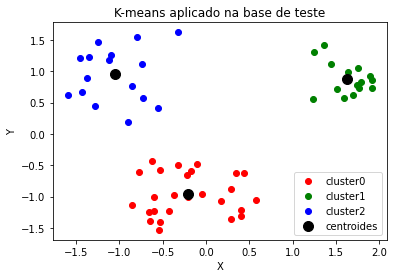

In [13]:
clusters, centroides = kmeans(3, pd.DataFrame(df_test), 100)

cores = ['r', 'g', 'b']
for i in range(0,len(clusters)):
    arr = np.array(clusters[i])
    x, y = arr.T
    plt.scatter(x, y, c=cores[i], label='cluster'+str(i))

arr_centroides = np.array(centroides)
x, y = arr_centroides.T
plt.scatter(x, y, 100, c='black', label='centroides')
    
plt.xlabel('X')
plt.ylabel('Y')
plt.title("K-means aplicado na base de teste")
plt.legend()
plt.show()

### 1.4 Segundo dataset: classificação de ataques cardíacos

O arquivo está nomeado como *heart.csv* e pode ser obtido através do link a seguir: https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset. Abaixo, temos a importação dos dados.

In [14]:
heart_df = pd.read_csv('heart.csv')

Agora fazemos a normalização dos dados e separamos nossa base em teste e treinamento.

In [15]:
X = heart_df.drop(["output"], axis=1)
X_train = StandardScaler().fit_transform(X[:273])
X_test = StandardScaler().fit_transform(X[273:])

Treino dos dados utilizando *kmeans*:

In [16]:
clusters, centroides = kmeans(3, pd.DataFrame(X_train), 100)

Não conseguimos plotar o gráfico para essa situação já que nosso dataset tem 13 features. Porém segue a divisão dos dados entre os clusters e os centroides.

In [17]:
custom_DBSCAN = CustomDBSCAN()
ponto_labels, clusters = custom_DBSCAN.fit(X_train, 0.25, 4)

Também não conseguimos plotar pelo mesmo motivo com o DBSCAN.

Abaixo, fazemos uma análise com o Silhouette para verificar qual a quantidade de clusters indicado no K-Means para nosso dataset.

Se a quantidade de clusters for 2 , a média do Silhouette Coefficient é: -0.009133881157271638
Se a quantidade de clusters for 3 , a média do Silhouette Coefficient é: -0.03985786051505981
Se a quantidade de clusters for 4 , a média do Silhouette Coefficient é: -0.006645877932487736
Se a quantidade de clusters for 5 , a média do Silhouette Coefficient é: -0.03376550175147804
Se a quantidade de clusters for 6 , a média do Silhouette Coefficient é: -0.047386870611773255


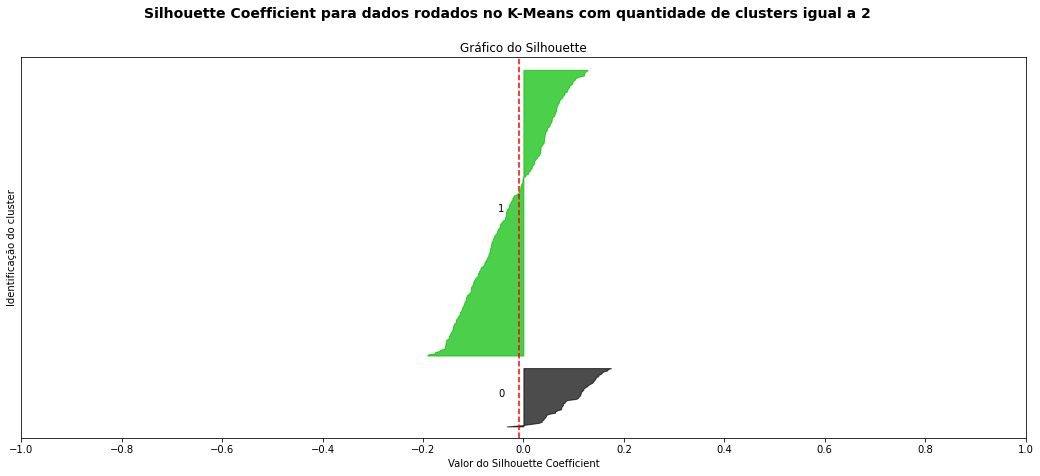

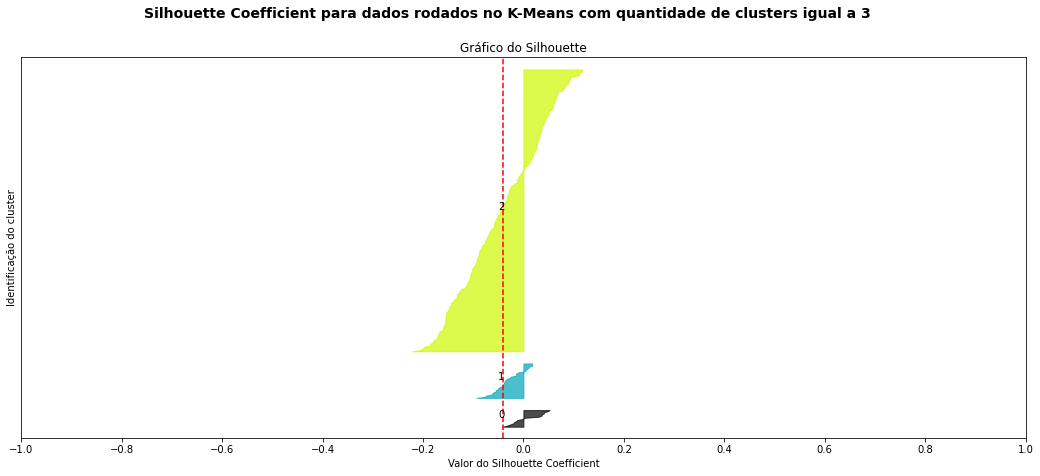

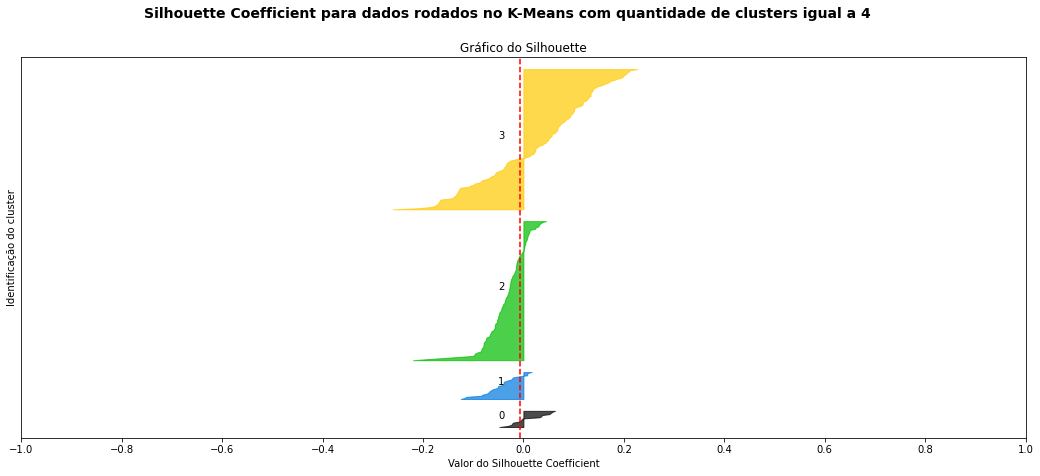

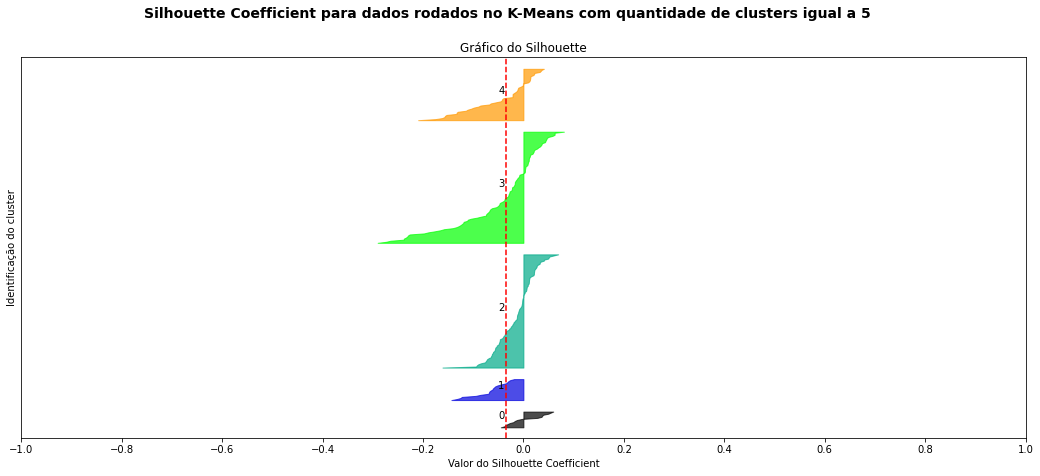

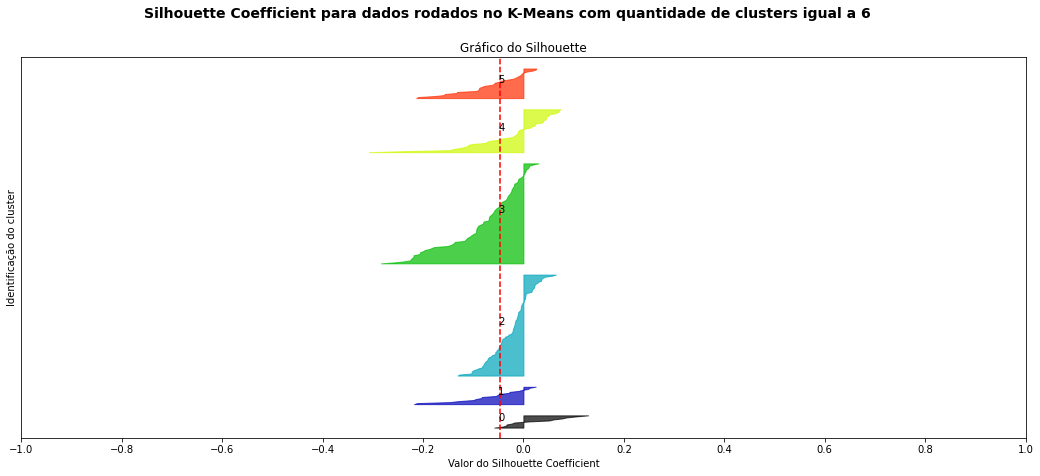

In [18]:
X = StandardScaler().fit_transform(X)

intervalo_qtd_clusters = [2, 3, 4, 5, 6]

for qtd_clusters in intervalo_qtd_clusters:
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (qtd_clusters + 1) * 10])

    clusters, centroides = kmeans(qtd_clusters, pd.DataFrame(X), 100)
    cluster_labels = np.array([])
    centroides_array = []
    
    centroides = np.asarray(centroides)
    
    for i in range(0, len(centroides)):
        centroides_array.append(centroides[i][0])
        
    centroides_array = np.asarray(centroides_array)
    
    for i in range(0,len(clusters)):
        arr = np.array(clusters[i])
        for j in range(0, len(arr.T[0])):
            cluster_labels = np.append(cluster_labels, i)

    silhouette_media = silhouette_score(X, cluster_labels)
    print("Se a quantidade de clusters for", qtd_clusters,
          ", a média do Silhouette Coefficient é:", silhouette_media)

    amostra_valores_silhouette = silhouette_samples(X, cluster_labels)

    y_menor = 10
    for i in range(qtd_clusters):
        cluster_silhouette_valores_i = \
            amostra_valores_silhouette[cluster_labels == i]

        cluster_silhouette_valores_i.sort()

        tamanho_cluster_i = cluster_silhouette_valores_i.shape[0]
        y_maior = y_menor + tamanho_cluster_i

        cor = cm.nipy_spectral(float(i) / qtd_clusters)
        ax1.fill_betweenx(np.arange(y_menor, y_maior),
                          0, cluster_silhouette_valores_i,
                          facecolor=cor, edgecolor=cor, alpha=0.7)

        ax1.text(-0.05, y_menor + 0.5 * tamanho_cluster_i, str(i))

        y_menor = y_maior + 10 

    ax1.set_title("Gráfico do Silhouette")
    ax1.set_xlabel("Valor do Silhouette Coefficient")
    ax1.set_ylabel("Identificação do cluster")

    ax1.axvline(x=silhouette_media, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    cores = cm.nipy_spectral(cluster_labels.astype(float) / qtd_clusters)

    plt.suptitle(("Silhouette Coefficient para dados rodados no K-Means "
                  "com quantidade de clusters igual a %d" % qtd_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

A melhor quantidade de clusters indicada para nosso dataset é 2 já que é o que nos dá o coeficiente com cluster mais distantes.

## Parte 2: Redução de dimensionalidade

O PCA é uma forma de reduzir dimensionalidade de dataset com grandes quantidades de features. É um procedimento estatístico que utiliza projeção ortogonal que converte um conjunto de variáveis correlacionadas em um conjunto de variáveis não correlacionadas.

Nessa parte do projeto, aplicamos o PCA para nos retorna dois e três componentes fazemos uma análise com o silhouette para verificar qual a quantidade de cluster indicado em cada caso.

Abaixo, aplicação do PCA com 2 componentes nos dados sendo rodado no K-Means com 2 clusters.

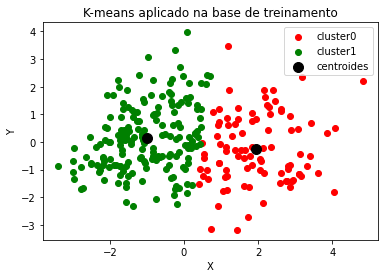

In [19]:
pca = PCA(n_components = 2)
pca.fit(X_train)
x_pca = pca.transform(X_train)

clusters, centroides = kmeans(2, pd.DataFrame(x_pca), 100)

cores = ['r', 'g', 'b']
for i in range(0,len(clusters)):
    arr = np.array(clusters[i])
    x, y = arr.T
    plt.scatter(x, y, c=cores[i], label='cluster'+str(i))

arr_centroides = np.array(centroides)
x, y = arr_centroides.T
plt.scatter(x, y, 100, c='black', label='centroides')
    
plt.xlabel('X')
plt.ylabel('Y')
plt.title("K-means aplicado na base de treinamento")
plt.legend()
plt.show()

Abaixo, aplicação do PCA com 2 componentes nos dados sendo rodado no K-Means com 3 clusters.

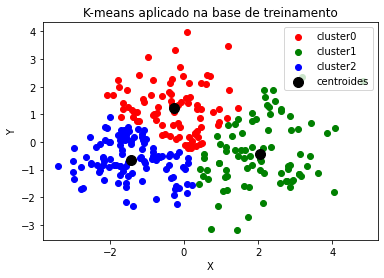

In [20]:
pca = PCA(n_components = 2)
pca.fit(X_train)
x_pca = pca.transform(X_train)


clusters, centroides = kmeans(3, pd.DataFrame(x_pca), 100)

cores = ['r', 'g', 'b']
for i in range(0,len(clusters)):
    arr = np.array(clusters[i])
    x, y = arr.T
    plt.scatter(x, y, c=cores[i], label='cluster'+str(i))

arr_centroides = np.array(centroides)
x, y = arr_centroides.T
plt.scatter(x, y, 100, c='black', label='centroides')
    
plt.xlabel('X')
plt.ylabel('Y')
plt.title("K-means aplicado na base de treinamento")
plt.legend()
plt.show()

Abaixo, aplicação do PCA com 2 componentes nos dados sendo rodado no K-Means com 4 clusters.

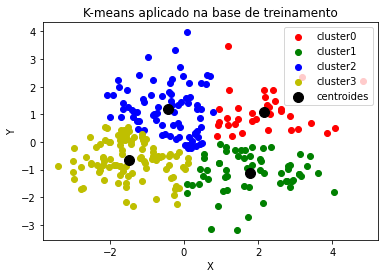

In [21]:
pca = PCA(n_components = 2)
pca.fit(X_train)
x_pca = pca.transform(X_train)

clusters, centroides = kmeans(4, pd.DataFrame(x_pca), 100)

cores = ['r', 'g', 'b', 'y']
for i in range(0,len(clusters)):
    arr = np.array(clusters[i])
    x, y = arr.T
    plt.scatter(x, y, c=cores[i], label='cluster'+str(i))

arr_centroides = np.array(centroides)
x, y = arr_centroides.T
plt.scatter(x, y, 100, c='black', label='centroides')
    
plt.xlabel('X')
plt.ylabel('Y')
plt.title("K-means aplicado na base de treinamento")
plt.legend()
plt.show()

Abaixo fazemos uma análise do com o Silhouette Coeffient para identificar qual a melhor quantidade de clusters para o nosso dataset com o PCA aplicado com 2 componentes.

Se a quantidade de clusters for 2 , a média do Silhouette Coefficient é: 0.06636455661275167
Se a quantidade de clusters for 3 , a média do Silhouette Coefficient é: 0.05680560296404003
Se a quantidade de clusters for 4 , a média do Silhouette Coefficient é: 0.017888369325199206


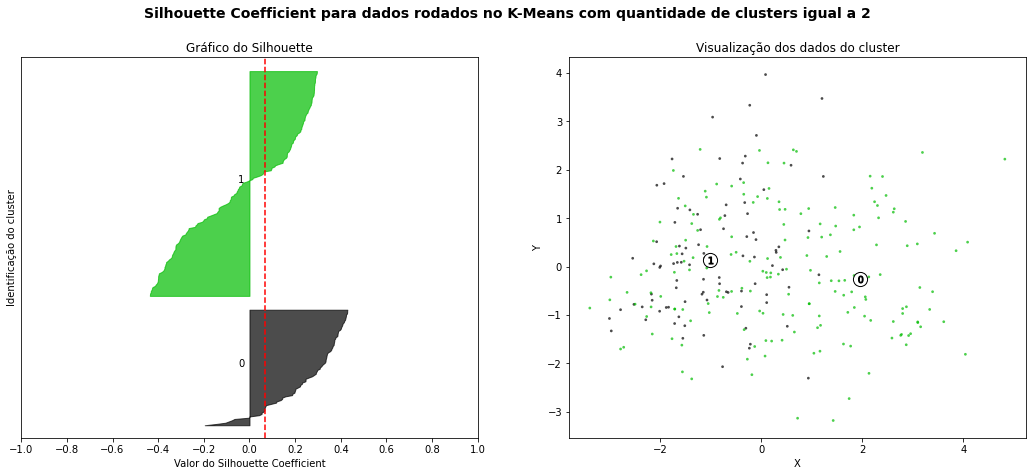

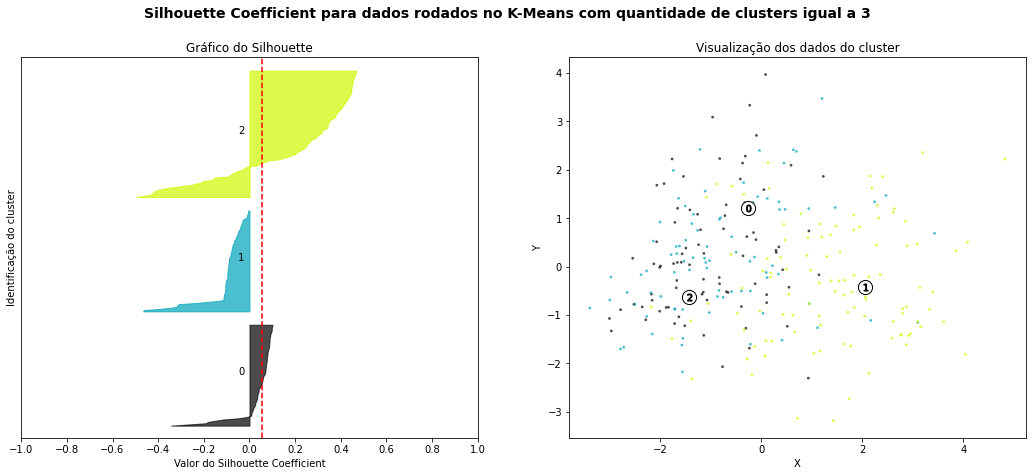

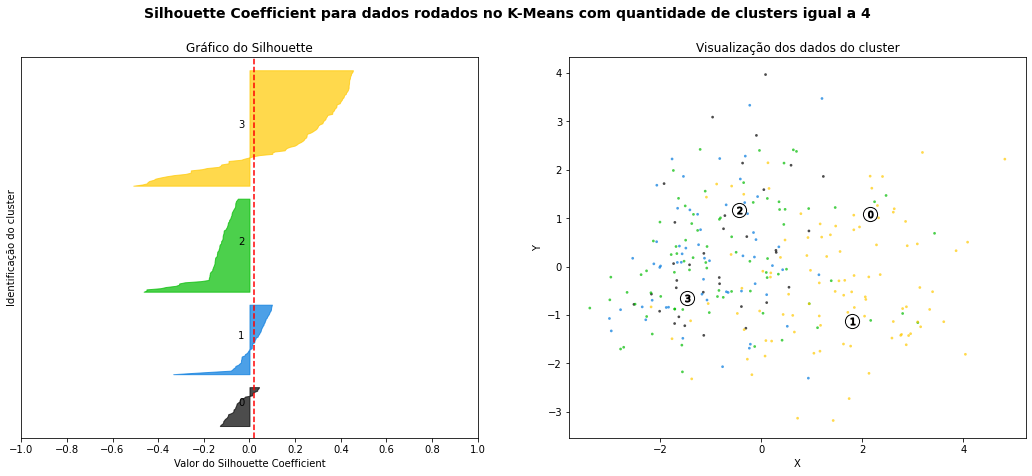

In [22]:
intervalo_qtd_clusters = [2, 3, 4]

for qtd_clusters in intervalo_qtd_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(x_pca) + (qtd_clusters + 1) * 10])

    clusters, centroides = kmeans(qtd_clusters, pd.DataFrame(x_pca), 100)
    cluster_labels = np.array([])
    centroides_array = []
    
    centroides = np.asarray(centroides)
    
    for i in range(0, len(centroides)):
        centroides_array.append(centroides[i][0])
        
    centroides_array = np.asarray(centroides_array)
    
    for i in range(0,len(clusters)):
        arr = np.array(clusters[i])
        x, y = arr.T
        for j in range(0, len(x)):
            cluster_labels = np.append(cluster_labels, i)

    silhouette_media = silhouette_score(x_pca, cluster_labels)
    print("Se a quantidade de clusters for", qtd_clusters,
          ", a média do Silhouette Coefficient é:", silhouette_media)

    amostra_valores_silhouette = silhouette_samples(x_pca, cluster_labels)

    y_menor = 10
    for i in range(qtd_clusters):
        cluster_silhouette_valores_i = \
            amostra_valores_silhouette[cluster_labels == i]

        cluster_silhouette_valores_i.sort()

        tamanho_cluster_i = cluster_silhouette_valores_i.shape[0]
        y_maior = y_menor + tamanho_cluster_i

        cor = cm.nipy_spectral(float(i) / qtd_clusters)
        ax1.fill_betweenx(np.arange(y_menor, y_maior),
                          0, cluster_silhouette_valores_i,
                          facecolor=cor, edgecolor=cor, alpha=0.7)

        ax1.text(-0.05, y_menor + 0.5 * tamanho_cluster_i, str(i))

        y_menor = y_maior + 10 

    ax1.set_title("Gráfico do Silhouette")
    ax1.set_xlabel("Valor do Silhouette Coefficient")
    ax1.set_ylabel("Identificação do cluster")

    ax1.axvline(x=silhouette_media, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    cores = cm.nipy_spectral(cluster_labels.astype(float) / qtd_clusters)
    ax2.scatter(x_pca[:, 0], x_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=cores, edgecolor='k')

    centroides = centroides_array
    
    ax2.scatter(centroides[:, 0], centroides[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centroides):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualização dos dados do cluster")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")

    plt.suptitle(("Silhouette Coefficient para dados rodados no K-Means "
                  "com quantidade de clusters igual a %d" % qtd_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Para dois componentes no PCA a melhor quantidade de clusters indicada no Silhouette Coefficent foi 2 cluster.

Agora alteramos a quantidade de componentes do PCA para 3 e rodamos o K-Means com 2 clusters.

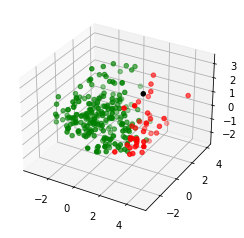

In [23]:
pca = PCA(n_components = 3)
pca.fit(X_train)
x_pca = pca.transform(X_train)
  
clusters, centroides = kmeans(2, pd.DataFrame(x_pca), 100)

fig = plt.figure()
ax = plt.axes(projection='3d')

cores = ['r', 'g', 'b']
for i in range(0,len(clusters)):
    arr = np.array(clusters[i])
    x, y, z = arr.T
    ax.scatter3D(x, y, z, color=cores[i]);

arr_centroides = np.array(centroides)
x, y, z = arr_centroides.T
ax.scatter3D(x, y, z, color='black');


Abaixo, aplicação do PCA com 3 componentes nos dados sendo rodado no K-Means com 3 clusters.

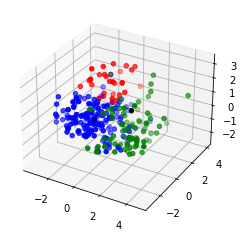

In [24]:
pca = PCA(n_components = 3)
pca.fit(X_train)
x_pca = pca.transform(X_train)
  
clusters, centroides = kmeans(3, pd.DataFrame(x_pca), 100)

fig = plt.figure()
ax = plt.axes(projection='3d')

cores = ['r', 'g', 'b']
for i in range(0,len(clusters)):
    arr = np.array(clusters[i])
    x, y, z = arr.T
    ax.scatter3D(x, y, z, color=cores[i]);

arr_centroides = np.array(centroides)
x, y, z = arr_centroides.T
ax.scatter3D(x, y, z, color='black');

Abaixo, aplicação do PCA com 3 componentes nos dados sendo rodado no K-Means com 4 clusters.

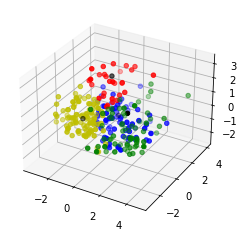

In [25]:
pca = PCA(n_components = 3)
pca.fit(X_train)
x_pca = pca.transform(X_train)
  
clusters, centroides = kmeans(4, pd.DataFrame(x_pca), 100)

fig = plt.figure()
ax = plt.axes(projection='3d')

cores = ['r', 'g', 'b', 'y']
for i in range(0,len(clusters)):
    arr = np.array(clusters[i])
    x, y, z = arr.T
    ax.scatter3D(x, y, z, color=cores[i]);

arr_centroides = np.array(centroides)
x, y, z = arr_centroides.T
ax.scatter3D(x, y, z, color='black');

Abaixo fazemos uma análise com o Silhouette Coefficient para verificar qual a melhor quantidade de clusters quando utilizamos 3 componentes no PCA.

Se a quantidade de clusters for 2 , a média do Silhouette Coefficient é: -0.014291736512072958
Se a quantidade de clusters for 3 , a média do Silhouette Coefficient é: -0.011145377148610627
Se a quantidade de clusters for 4 , a média do Silhouette Coefficient é: 0.02604990450993875


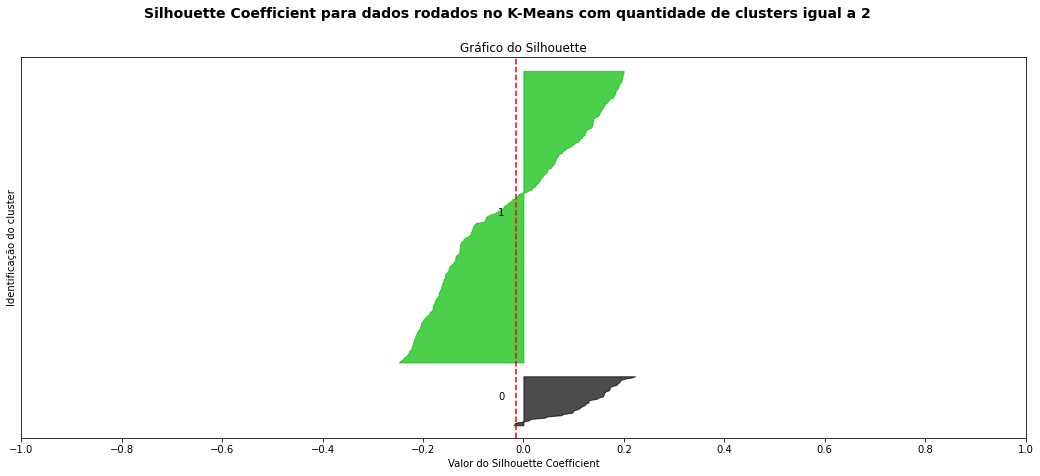

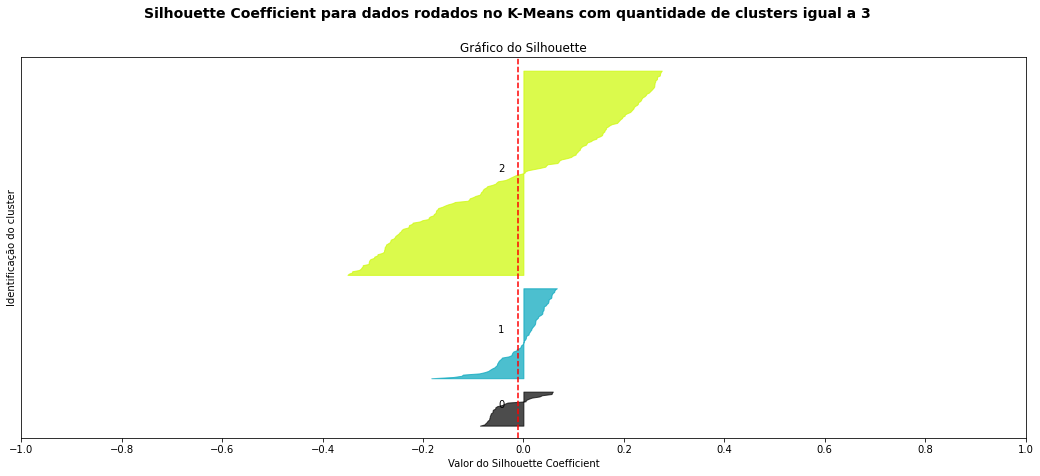

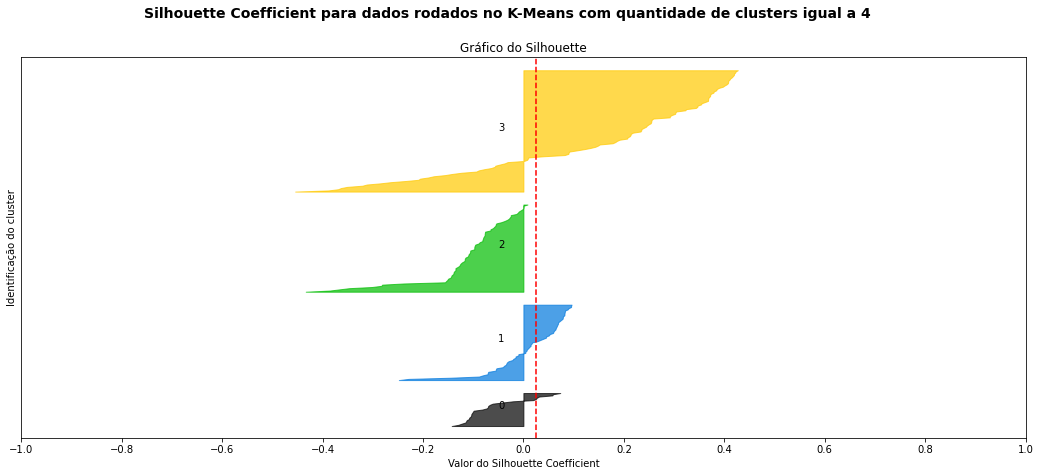

In [26]:
intervalo_qtd_clusters = [2, 3, 4]

for qtd_clusters in intervalo_qtd_clusters:
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(x_pca) + (qtd_clusters + 1) * 10])

    clusters, centroides = kmeans(qtd_clusters, pd.DataFrame(x_pca), 100)
    cluster_labels = np.array([])
    centroides_array = []
    
    centroides = np.asarray(centroides)
    
    for i in range(0, len(centroides)):
        centroides_array.append(centroides[i][0])
        
    centroides_array = np.asarray(centroides_array)
    
    for i in range(0,len(clusters)):
        arr = np.array(clusters[i])
        for j in range(0, len(arr.T[0])):
            cluster_labels = np.append(cluster_labels, i)

    silhouette_media = silhouette_score(x_pca, cluster_labels)
    print("Se a quantidade de clusters for", qtd_clusters,
          ", a média do Silhouette Coefficient é:", silhouette_media)

    amostra_valores_silhouette = silhouette_samples(x_pca, cluster_labels)

    y_menor = 10
    for i in range(qtd_clusters):
        cluster_silhouette_valores_i = \
            amostra_valores_silhouette[cluster_labels == i]

        cluster_silhouette_valores_i.sort()

        tamanho_cluster_i = cluster_silhouette_valores_i.shape[0]
        y_maior = y_menor + tamanho_cluster_i

        cor = cm.nipy_spectral(float(i) / qtd_clusters)
        ax1.fill_betweenx(np.arange(y_menor, y_maior),
                          0, cluster_silhouette_valores_i,
                          facecolor=cor, edgecolor=cor, alpha=0.7)

        ax1.text(-0.05, y_menor + 0.5 * tamanho_cluster_i, str(i))

        y_menor = y_maior + 10 

    ax1.set_title("Gráfico do Silhouette")
    ax1.set_xlabel("Valor do Silhouette Coefficient")
    ax1.set_ylabel("Identificação do cluster")

    ax1.axvline(x=silhouette_media, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    cores = cm.nipy_spectral(cluster_labels.astype(float) / qtd_clusters)

    plt.suptitle(("Silhouette Coefficient para dados rodados no K-Means "
                  "com quantidade de clusters igual a %d" % qtd_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Rodando o PCA utilizando 3 componentes e testantando a quantidade de clusters de 2 a 4, temos que a opção que menos convém é utilizar 4 clusters.

Após testar e validar com a técnica de Silhouette Coefficient diversas formas e valores para o número de clusters e componentes, podemos concluir que a melhor configuração para o número de clusters é 2, ou seja, do dataset obtido a respeito de ataques cardíacos é possível obter a melhor subdivisão com dois grupos.